In [3]:
import sklearn.decomposition
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt

In [8]:
from data_preprocessing import *
train_loader, test_loader = get_datasets_full_length_loader("dataset")

/home/s1928563/programs/miniconda3/envs/adbench/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
images_all, labels_all = next(iter(train_loader))

# convert to 1D
images_flat = images_all[:, 0].reshape(-1, 784).numpy()
images_flat.shape

(249073, 784)

In [11]:
component_range = np.array(list(range(1, 11)) + [50, 100, 200, 500])
print(f"training components: {component_range.max()}")
pca = sklearn.decomposition.PCA(n_components=component_range.max())
images_flat_hat = pca.inverse_transform(pca.fit_transform(images_flat))

training components: 500


In [12]:
images_flat_hat.shape

(249073, 784)

In [13]:
def transform_truncated(pca, X, n_components):
    X = pca._validate_data(X, dtype=[np.float64, np.float32], reset=False)
    if pca.mean_ is not None:
        X = X - pca.mean_
    X_transformed = np.dot(X, pca.components_[:n_components, :].T)
    if pca.whiten:
        X_transformed /= np.sqrt(pca.explained_variance_)
    return X_transformed

def inv_transform(pca, X, n_components):
    return np.dot(X, pca.components_[:n_components, :]) + pca.mean_

def inv_forward_transform(pca, X, n_components):
    return inv_transform(
        pca, transform_truncated(pca, X, n_components), n_components
    )

# get reconstruction error for different n_components
mse_train_pca = []
for n in component_range:
    print(f"mse: {n}")
    images_flat_hat = inv_forward_transform(pca, X=images_flat, n_components=n)
    _loss = sklearn.metrics.mean_squared_error(images_flat_hat, images_flat)
    mse_train_pca.append(_loss)

mse: 1
mse: 2
mse: 3
mse: 4
mse: 5
mse: 6
mse: 7
mse: 8
mse: 9
mse: 10
mse: 50
mse: 100
mse: 200
mse: 500


Text(0, 0.5, 'MSE')

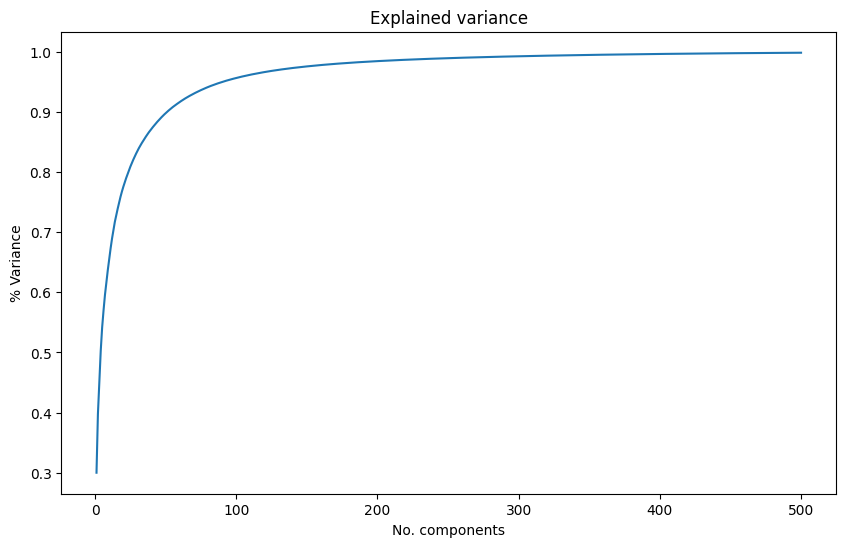

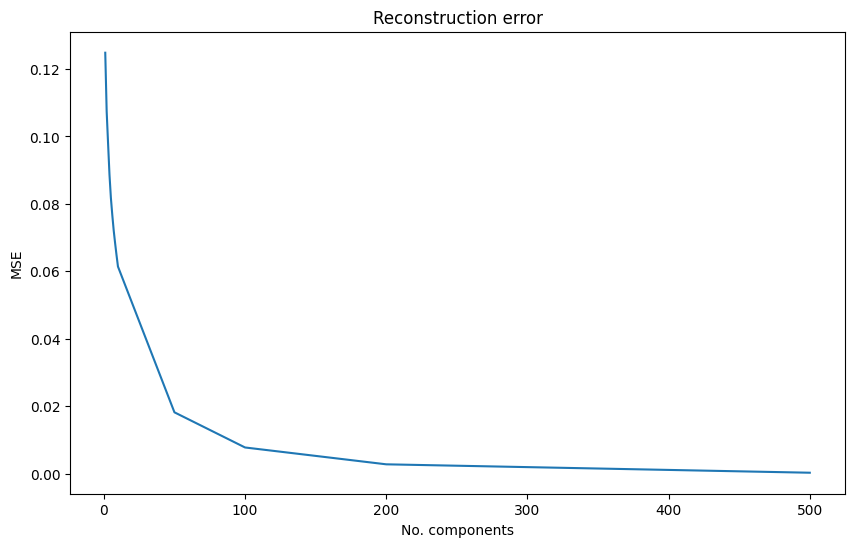

In [15]:
# explained variance
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(1, pca.n_components_ + 1), np.cumsum(pca.explained_variance_ratio_)
)
ax.set_title("Explained variance")
ax.set_xlabel("No. components")
ax.set_ylabel("% Variance")

# reconstruction mse
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(component_range, mse_train_pca)
ax.set_title("Reconstruction error")
ax.set_xlabel("No. components")
ax.set_ylabel("MSE")

### We choose 150 components